## import libs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pwd

'/content'

In [3]:
%cd drive/MyDrive/RA_Project/

/content/drive/MyDrive/RA_Project


In [4]:

import pandas as pd

import numpy as np
import seaborn as sns
import csv

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
import os
import warnings

In [6]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, classification_report

In [7]:
warnings.filterwarnings(action="ignore")
pd.options.display.max_columns = None

In [8]:
fig_size = (10, 6)

In [9]:
from math import radians, cos, sin, asin, sqrt
from scipy.spatial.distance import cdist

In [10]:
%pwd

'/content/drive/MyDrive/RA_Project'

In [11]:
from staypoint_detection import *

## read data

In [12]:
# read pickle file
raw_df = pd.read_pickle('data/all_participants_gps_wd_trvldiary_merged.pkl')

In [13]:
raw_df.groupby("Subject").agg({"timediff":[pd.Series.mode, "count"]}).reset_index()

Subject timediff       
              mode  count
0  S01_MW      5.0   8047
1  S02_KQ     10.0  12359
2  S03_DM      5.0   3681
3  S04_MM      5.0  29043
4  S05_AK      5.0  18299
5  S06_GS      5.0  28930
6  S08_GT      5.0   8919
7  S09_JA      5.0  14578
8  S10_SR      5.0   6944
9  S11_CP      5.0  17952

# Data processing

## add gap label
Add time gap interval label to identify signal loss

In [14]:
transform_df = raw_df.copy()

In [15]:
transform_df.head()

,OID_,OID1,OID1_1,INDEX,UTC_DATE,UTC_TIME,LOCAL_DATE,LOCAL_TIME,MS,VALID,LATITUDE,N_S,LONGITUDE,E_W,HEIGHT,SPEED,HEADING,HDOP,NSAT_USED_VIEW_,NSAT_USED_VIEW__X,NSAT_USED_VIEW__Y,SAT_INFO__SID_ELE_AZI_SNR__,datetimetx,datetime,uid,lon_dd,lat_dd,POINT_X,POINT_Y,NoSAT,SPEED_KH,SNR,sat_ratio,SPEED_MS,timediff,locdiff,espd_ms,GapType,heading2,headdiff2,spdkh,Outlier_info,Kushal_Outlier,Mode,Final_Label,file_name,outlier_info,mode,Outlier_Kushal,oldx,oldy,NSAT_USED_VIEW__X_,NSAT_USED_VIEW__Y_,kushal_outlier,Longitude_x,Latitude_x,outlie_info,Kushal_outlier,tmp_dateime,participant_x,Subject,STCid,Begin_Time,End_Time,Mode_of_Trip,Typeloc,Origin,City,State,Latitude_y,Longitude_y,Destination,Activity,Subjects' Notes,Unnamed: 14,Unnamed: 15,Unnamed: 16,participant_y
0,337.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.99,0/ 2,2,0,13-03-329-00;08-65-66-00\r,4/27/2017 13:40,2017-04-27 13:40:00,337.0,NaN,NaN,358716.5854,578992.6498,0.0,0.000,0.0,0.000000,0.000000,2508.0,190,0.0757213,NaN,18.329248,39.512794,0.000,NaN,NaN,walk,0,partic1.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87.625950,41.879795,NaN,NaN,NaT,1,S01_MW,7,2017-04-27 13:39:00,2017-04-27 13:45:00,Walk,1,14 E Jackson,Chicago,IL,41.878407,-87.627062,Goddess and the Grocer/ Wabash,Commuting,2,NaN,NaN,NaN,1
1,338.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.08,9-Jul,9,7,07-88-344-38;28-30-271-28;30-47-309-22;08-64-6...,4/27/2017 13:41,2017-04-27 13:41:28,338.0,NaN,NaN,358716.5854,578992.6498,7.0,2.192,218.0,0.777778,0.608889,88.0,0,0,NaN,360.000000,161.670746,2.192,NaN,NaN,walk,0,partic1.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87.625950,41.879795,NaN,NaN,NaT,1,S01_MW,7,2017-04-27 13:39:00,2017-04-27 13:45:00,Walk,1,14 E Jackson,Chicago,IL,41.878407,-87.627062,Goddess and the Grocer/ Wabash,Commuting,2,NaN,NaN,NaN,1
2,339.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.08,10-Jul,10,7,07-88-344-39;28-30-271-25;30-47-309-22;08-64-6...,4/27/2017 13:41,2017-04-27 13:41:33,339.0,NaN,NaN,358712.5933,578993.6666,7.0,2.483,213.0,0.700000,0.689723,5.0,4,0.8239112,NaN,284.289581,104.289581,2.483,NaN,NaN,walk,0,partic1.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87.625998,41.879805,NaN,NaN,NaT,1,S01_MW,7,2017-04-27 13:39:00,2017-04-27 13:45:00,Walk,1,14 E Jackson,Chicago,IL,41.878407,-87.627062,Goddess and the Grocer/ Wabash,Commuting,2,NaN,NaN,NaN,1
3,340.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.08,10-Jul,10,7,07-88-344-38;28-30-271-22;30-47-309-24;08-64-6...,4/27/2017 13:41,2017-04-27 13:41:38,340.0,NaN,NaN,358713.3964,578990.3054,7.0,3.280,216.0,0.700000,0.911112,5.0,3,0.6911623,NaN,166.562118,62.272537,3.280,NaN,NaN,walk,0,partic1.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87.625989,41.879774,NaN,NaN,NaT,1,S01_MW,7,2017-04-27 13:39:00,2017-04-27 13:45:00,Walk,1,14 E Jackson,Chicago,IL,41.878407,-87.627062,Goddess and the Grocer/ Wabash,Commuting,2,NaN,NaN,NaN,1
4,341.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.08,10-Jul,10,7,07-88-344-39;28-30-271-22;30-47-309-21;08-64-6...,4/27/2017 13:41,2017-04-27 13:41:43,341.0,NaN,NaN,358714.2323,578987.0822,7.0,3.245,203.0,0.700000,0.901390,5.0,3,0.6659653,NaN,165.461288,178.899170,3.245,NaN,NaN,walk,0,partic1.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87.625979,41.879745,NaN,NaN,NaT,1,S01_MW,7,2017-04-27 13:39:00,2017-04-27 13:45:00,Walk,1,14 E Jackson,Chicago,IL,41.878407,-87.627062,Goddess and the Grocer/ Wabash,Commuting,2,NaN,NaN,NaN,1


In [17]:
transform_df.sort_values("datetime", ascending=True).groupby("Subject")\
                                                ['datetime'].shift(periods=1)

0                       NaT
1       2017-04-27 13:40:00
2       2017-04-27 13:41:28
3       2017-04-27 13:41:33
4       2017-04-27 13:41:38
                ...        
17949   2017-06-29 06:46:33
17950   2017-06-29 06:46:38
17951   2017-06-29 06:46:43
17952   2017-06-29 06:46:48
17953   2017-06-29 06:46:53
Name: datetime, Length: 148758, dtype: datetime64[ns]

In [23]:
grp_df = transform_df.groupby("Subject")

In [27]:
new_gps_df = pd.DataFrame()
for group in grp_df.groups:
    tmp_df = grp_df.get_group(group)
    shifted_stamps = tmp_df.sort_values("datetime", ascending=True).groupby("Subject")\
          ['datetime'].shift(periods=1)
    tmp_df['prev_datetime'] = shifted_stamps
    tmp_df['time_diff_sec'] = (tmp_df.datetime - tmp_df.prev_datetime).dt.seconds
    new_gps_df = pd.concat([new_gps_df, tmp_df], axis=0)

In [28]:
pd.DataFrame(new_gps_df.isna().sum()).T

,OID_,OID1,OID1_1,INDEX,UTC_DATE,UTC_TIME,LOCAL_DATE,LOCAL_TIME,MS,VALID,LATITUDE,N_S,LONGITUDE,E_W,HEIGHT,SPEED,HEADING,HDOP,NSAT_USED_VIEW_,NSAT_USED_VIEW__X,NSAT_USED_VIEW__Y,SAT_INFO__SID_ELE_AZI_SNR__,datetimetx,datetime,uid,lon_dd,lat_dd,POINT_X,POINT_Y,NoSAT,SPEED_KH,SNR,sat_ratio,SPEED_MS,timediff,locdiff,espd_ms,GapType,heading2,headdiff2,spdkh,Outlier_info,Kushal_Outlier,Mode,Final_Label,file_name,outlier_info,mode,Outlier_Kushal,oldx,oldy,NSAT_USED_VIEW__X_,NSAT_USED_VIEW__Y_,kushal_outlier,Longitude_x,Latitude_x,outlie_info,Kushal_outlier,tmp_dateime,participant_x,Subject,STCid,Begin_Time,End_Time,Mode_of_Trip,Typeloc,Origin,City,State,Latitude_y,Longitude_y,Destination,Activity,Subjects' Notes,Unnamed: 14,Unnamed: 15,Unnamed: 16,participant_y,prev_datetime,time_diff_sec
0,0,148758,148758,8052,8052,8052,8047,8047,8052,8052,8052,8052,8052,8052,8052,8047,8052,5,5,5,5,5,5,0,5,8052,8052,0,0,5,0,5,5,0,6,6,6,148128,6,6,5,115489,79969,10706,0,0,81078,139839,123859,119828,119828,103675,103675,130196,140711,140711,120961,120902,8047,0,0,0,0,0,1018,0,0,1357,36,0,0,126663,116588,141640,124148,120543,148528,0,10,10


In [29]:
new_gps_df.Subject.nunique()

10

In [31]:
new_gps_df.time_diff_sec.describe()

count    148748.000000
mean         11.379044
std         398.551495
min           0.000000
25%           5.000000
50%           5.000000
75%           5.000000
max       55456.000000
Name: time_diff_sec, dtype: float64

In [33]:
new_gps_df.drop_duplicates(['Subject', 'datetime'], keep='first', inplace=True)

ValueError: ignored

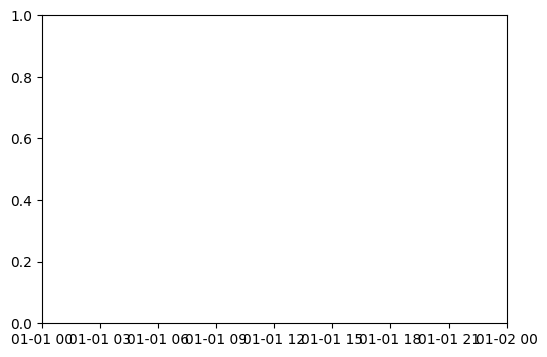

In [36]:
# plt.figure(figsize=(6, 4))
# sns.lineplot(x='datetime', y='time_diff_sec', data=new_gps_df, markers='o')

In [34]:
new_gps_df.groupby(['Subject', "Mode_of_Trip"])['time_diff_sec'].quantile([0, 0.25, 0.5, 0.75, 0.95, .99, 1])

Subject  Mode_of_Trip      
S01_MW   Stop          0.00      1.0
                       0.25      5.0
                       0.50      5.0
                       0.75      5.0
                       0.95      5.0
                               ...  
S11_CP   Walk          0.50      5.0
                       0.75      5.0
                       0.95      5.0
                       0.99     33.1
                       1.00    303.0
Name: time_diff_sec, Length: 224, dtype: float64

# Subject (10 sec)

In [37]:
new_gps_df.groupby("Subject").agg({"time_diff_sec":[pd.Series.mode, "count"]}).reset_index()

Subject time_diff_sec       
                   mode  count
0  S01_MW           5.0   8046
1  S02_KQ          10.0  12358
2  S03_DM           5.0   3681
3  S04_MM           5.0  29042
4  S05_AK           5.0  18298
5  S06_GS           5.0  28930
6  S08_GT           5.0   8918
7  S09_JA           5.0  14578
8  S10_SR           5.0   6944
9  S11_CP           5.0  17952

## Run staypoint detection

In [38]:
SUB_10 = 'S02_KQ'

In [39]:
sub_10 = new_gps_df[new_gps_df.Subject==SUB_10]

In [40]:
# points = []

time_format = '%Y-%m-%d %H:%M:%S'
# 2, 10
distane_thresh = 10 # (mtr)
time_diff = 60 # (sec)

In [41]:
points = parseGeoTxt(sub_10)

In [42]:
points[:3]

In [43]:
stayPointCenter, stayPoint = stayPointExtraction(points, distane_thresh, time_diff)

In [44]:
len(stayPoint)

5490

In [45]:
transform_df.shape

(148758, 78)

## Sensitivity analysis

In [46]:
dist_thr_lst1 = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2] # finer granularity
time_thr_lst1 = list(range(60, 1801, 30))

In [47]:
dist_thr_lst2 = list(range(2, 31, 2)) # coarse granularity
time_thr_lst2 = list(range(60, 1801, 30))

In [48]:
# time thresholds
time_thr_lst3 = list(range(1, 241, 5))
dist_thr_lst3 = list(range(2, 31, 2))

In [49]:
comb_lst1 = [(i, j) for i in time_thr_lst1 for j in dist_thr_lst1]

In [50]:
comb_lst2 = [(i, j) for i in time_thr_lst2 for j in dist_thr_lst2]

In [51]:
comb_lst2 = [comb for comb in comb_lst2 if comb not in comb_lst1]

In [52]:
comb_lst3 = [(i, j) for i in time_thr_lst3 for j in dist_thr_lst3]

In [53]:
comb_lst3 = [comb for comb in comb_lst3 if comb not in comb_lst1 and comb not in comb_lst2]

In [54]:
final_comb = comb_lst1 + comb_lst2 + comb_lst3

In [ ]:
results_df = pd.DataFrame()
for combination in final_comb:
  time_ = combination[0]
  dist_ = combination[1]
  points = parseGeoTxt(sub_10)
  stayPointCenter, stayPoint = stayPointExtraction(points, dist_, time_)
  if len(stayPointCenter) > 0:
    data_obj = [[dist_, time_, stayPoint, stayPointCenter]]
    res_tmp_df = pd.DataFrame(data_obj, columns = ['dist_thr', 'time_thr', 'stay_point', 'stay_point_center'])
    results_df = pd.concat([results_df, res_tmp_df], axis=0)

In [83]:
new_results_df = results_df.explode("stay_point")

In [84]:
new_results_df.shape

(8714534, 4)

In [85]:
lat = [i.latitude for i in new_results_df.stay_point]
long = [i.longitude for i in new_results_df.stay_point]
id_ = [i.id for i in new_results_df.stay_point]

In [86]:
new_results_df['lat'] = lat
new_results_df['long'] = long
new_results_df['id'] = id_

In [87]:
new_results_df.head()

,dist_thr,time_thr,stay_point,stay_point_center,lat,long,id
0,0.4,60,<staypoint_detection.Point object at 0x7cdaa22...,[<staypoint_detection.Point object at 0x7cdab8...,41.597462,88.025443,47
0,0.4,60,<staypoint_detection.Point object at 0x7cdaa22...,[<staypoint_detection.Point object at 0x7cdab8...,41.597462,88.025444,48
0,0.4,60,<staypoint_detection.Point object at 0x7cdaa22...,[<staypoint_detection.Point object at 0x7cdab8...,41.597462,88.025444,49
0,0.4,60,<staypoint_detection.Point object at 0x7cdaa22...,[<staypoint_detection.Point object at 0x7cdab8...,41.597462,88.025444,50
0,0.4,60,<staypoint_detection.Point object at 0x7cdaa22...,[<staypoint_detection.Point object at 0x7cdab8...,41.597462,88.025445,51


In [88]:
transform_df.reset_index(drop=False, inplace=True)

In [89]:
transform_df.Mode_of_Trip.unique()

array(['Driving ', 'Stop', nan], dtype=object)

In [90]:
transform_df.Mode_of_Trip.value_counts(dropna=False)

Stop        10358
Driving      1887
NaN           114
Name: Mode_of_Trip, dtype: int64

In [91]:
metrics_df = pd.DataFrame()
for comb in final_comb:
  time_ = comb[0]
  dist_ = comb[1]
  tmp_df = new_results_df[(new_results_df.time_thr==time_) & (new_results_df.dist_thr==dist_)]
  new_df = transform_df.merge(tmp_df, how = 'left', left_on = 'index', right_on='id')
  # print(new_df.isna().sum()['id'])
  new_df['target'] = np.where(new_df.Mode_of_Trip=='Stop', 1, 0)
  new_df['pred'] = np.where(new_df.id.isna(), 0, 1)

  recall_scr = recall_score(new_df.target, new_df.pred)
  precision_scr = precision_score(new_df.target, new_df.pred)
  f1_scr = f1_score(new_df.target, new_df.pred)
  tn, fp, fn, tp = confusion_matrix(new_df.target, new_df.pred).ravel()
  conf_matrix = classification_report(new_df.target, new_df.pred, output_dict=True)
  dd = pd.DataFrame(conf_matrix).transpose()

  prec_0 = dd.iloc[0,0]
  rec_0 = dd.iloc[0,1]
  prec_1 = dd.iloc[1,0]
  rec_1 = dd.iloc[1,1]
  support_0 = dd.iloc[0,3]
  support_1 = dd.iloc[1,3]

  data_obj = [[dist_, time_, recall_scr, precision_scr, tp, fp, tn, fn, f1_scr,
               prec_0, rec_0, prec_1, rec_1, support_0, support_1]]
  res_tmp_df = pd.DataFrame(data_obj, columns = ['dist_thr', 'time_thr', 'recall',
                                                 'precision', 'tp', 'fp', 'tn', 'fn', 'f1_score',
                                                 'prec_0', 'rec_0', 'prec_1', 'rec_1',
                                                 'support_0', 'support_1'])
  metrics_df = pd.concat([metrics_df, res_tmp_df], axis=0)

In [92]:
metrics_df.sort_values('rec_1', ascending=False)

,dist_thr,time_thr,recall,precision,tp,fp,tn,fn,f1_score,prec_0,rec_0,prec_1,rec_1,support_0,support_1
0,4.0,1,0.974899,0.957429,10098,449,1552,260,0.966085,0.856512,0.775612,0.957429,0.974899,2001.0,10358.0
0,4.0,6,0.974899,0.957429,10098,449,1552,260,0.966085,0.856512,0.775612,0.957429,0.974899,2001.0,10358.0
0,4.0,11,0.968141,0.965623,10028,357,1644,330,0.966880,0.832827,0.821589,0.965623,0.968141,2001.0,10358.0
0,4.0,16,0.967754,0.965889,10024,354,1647,334,0.966821,0.831398,0.823088,0.965889,0.967754,2001.0,10358.0
0,2.0,1,0.967079,0.961786,10017,398,1603,341,0.964425,0.824588,0.801099,0.961786,0.967079,2001.0,10358.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.4,1350,0.000000,0.000000,0,0,2001,10358,0.000000,0.161906,1.000000,0.000000,0.000000,2001.0,10358.0
0,0.4,1740,0.000000,0.000000,0,0,2001,10358,0.000000,0.161906,1.000000,0.000000,0.000000,2001.0,10358.0
0,0.6,1740,0.000000,0.000000,0,0,2001,10358,0.000000,0.161906,1.000000,0.000000,0.000000,2001.0,10358.0
0,0.8,1740,0.000000,0.000000,0,0,2001,10358,0.000000,0.161906,1.000000,0.000000,0.000000,2001.0,10358.0


In [93]:
metrics_df['accuracy'] = ((metrics_df['tp']+metrics_df['tn'])/(metrics_df['tp']+metrics_df['tn']+
                                                                metrics_df['fp']+metrics_df['fn']))

In [94]:
metrics_df.sort_values('accuracy', ascending=False)

,dist_thr,time_thr,recall,precision,tp,fp,tn,fn,f1_score,prec_0,rec_0,prec_1,rec_1,support_0,support_1,accuracy
0,4.0,36,0.958293,0.975432,9926,250,1751,432,0.966787,0.802107,0.875062,0.975432,0.958293,2001.0,10358.0,0.944818
0,4.0,31,0.958679,0.974963,9930,255,1746,428,0.966753,0.803128,0.872564,0.974963,0.958679,2001.0,10358.0,0.944737
0,4.0,11,0.968141,0.965623,10028,357,1644,330,0.966880,0.832827,0.821589,0.965623,0.968141,2001.0,10358.0,0.944413
0,4.0,16,0.967754,0.965889,10024,354,1647,334,0.966821,0.831398,0.823088,0.965889,0.967754,2001.0,10358.0,0.944332
0,4.0,46,0.955880,0.976815,9901,235,1766,457,0.966234,0.794422,0.882559,0.976815,0.955880,2001.0,10358.0,0.944008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.4,1440,0.000000,0.000000,0,0,2001,10358,0.000000,0.161906,1.000000,0.000000,0.000000,2001.0,10358.0,0.161906
0,0.6,1440,0.000000,0.000000,0,0,2001,10358,0.000000,0.161906,1.000000,0.000000,0.000000,2001.0,10358.0,0.161906
0,0.8,1440,0.000000,0.000000,0,0,2001,10358,0.000000,0.161906,1.000000,0.000000,0.000000,2001.0,10358.0,0.161906
0,0.4,930,0.000000,0.000000,0,0,2001,10358,0.000000,0.161906,1.000000,0.000000,0.000000,2001.0,10358.0,0.161906


# Subject (5 sec)

In [ ]:
raw_df

In [ ]:
transform_df = raw_df.query("Subject == @SENS_SUBJ")